In [1]:
using Lux, Random,TaylorDiff, ComponentArrays,Optimisers,Zygote,Plots,ForwardDiff, Statistics

In [3]:
rng = MersenneTwister()
Random.seed!(rng, 1)

# Define the model
model = Chain(Dense(1 => 50, tanh), Dense(50 => 50, tanh), Dense(50 => 1)) 

# Initialize model parameters
ps, st = Lux.setup(Xoshiro(0), model)
#ps = ps |> ComponentArray

# Function to evaluate the model
function trial(model, x, ps, st)
    u, st = Lux.apply(model, x, ps, st)
    return u
end

f(x) = trial(model, x, ps, st)

x = collect(range(-1f0, 1f0, length=200))
x = reshape(x, 1, :)
y = Float32.(cos.(x))
data = (x, y)

opt = Adam(0.01f0)

function trial(model, x, ps, st)
    u, st = Lux.apply(model, x, ps, st)
    return u
end

    #dydx = Zygote.gradient(sum ∘ smodel, x)[1]
    #print(dydx)  
    #loss = MSELoss()(d, data[2])

function loss_function(model, ps, st, data)
    x = data[1]
    f(x) = trial(model, x, ps, st)
    d = f(x)
    #dydx = TaylorDiff.derivative(f, x, Float32.(ones(size(x))), Val(1)) 
    #smodel = StatefulLuxLayer{true}(model, ps, st)
    #dydx = Zygote.gradient(sum ∘ StatefulLuxLayer{true}(tstate.model, tstate.parameters, tstate.states), x)
    #print(dydx)
    error = d .- data[2]
    loss = mean(error.^2)
    return loss, st, ()
end

ps, st = Lux.setup(rng, model)
loss_function(model, ps, st, data)

tstate = Training.TrainState(model, ps, st, opt)

grads, loss, stats, ts = Lux.Training.compute_gradients(AutoZygote(), loss_function, data, tstate)
Lux.Training.apply_gradients(ts, grads)

# Training loop
epochs = 5000
for epoch in 1:epochs
    grads, loss, stats, ts = Lux.Training.compute_gradients(AutoZygote(), loss_function, data, tstate)
    tstate = Lux.Training.apply_gradients(ts, grads)
    if epoch % 100 == 0
        println("Epoch: $epoch, Loss: $loss")
    end
end

Epoch: 100, Loss: 9.2041686e-5
Epoch: 200, Loss: 2.3943021e-5
Epoch: 300, Loss: 1.3304576e-5
Epoch: 400, Loss: 1.006307e-5
Epoch: 500, Loss: 8.013504e-6
Epoch: 600, Loss: 6.537302e-6
Epoch: 700, Loss: 5.4696675e-6
Epoch: 800, Loss: 4.67683e-6
Epoch: 900, Loss: 4.060914e-6
Epoch: 1000, Loss: 3.5580517e-6
Epoch: 1100, Loss: 3.130429e-6
Epoch: 1200, Loss: 8.34266e-6
Epoch: 1300, Loss: 3.2771097e-6
Epoch: 1400, Loss: 2.8803854e-6
Epoch: 1500, Loss: 2.5371392e-6
Epoch: 1600, Loss: 2.233566e-6
Epoch: 1700, Loss: 8.884234e-6
Epoch: 1800, Loss: 2.218052e-6
Epoch: 1900, Loss: 1.9036665e-6
Epoch: 2000, Loss: 1.6403837e-6
Epoch: 2100, Loss: 1.4173472e-6
Epoch: 2200, Loss: 1.2291441e-6
Epoch: 2300, Loss: 1.5624073e-6
Epoch: 2400, Loss: 9.771035e-7
Epoch: 2500, Loss: 8.555381e-7
Epoch: 2600, Loss: 7.5751376e-7
Epoch: 2700, Loss: 6.766129e-7
Epoch: 2800, Loss: 0.0004099977
Epoch: 2900, Loss: 6.218015e-7
Epoch: 3000, Loss: 5.331904e-7
Epoch: 3100, Loss: 4.841846e-7
Epoch: 3200, Loss: 4.453135e-7
Epoc

In [4]:
d = f(x)

1×200 Matrix{Float32}:
 1.05437  1.0584  1.06247  1.06659  …  -0.237983  -0.24013  -0.242256

In [5]:
dydx = TaylorDiff.derivative(f, x, Float32.(ones(size(x))), Val(1)) 

┌ Warning: Mixed-Precision `matmul_cpu_fallback!` detected and Octavian.jl cannot be used for this set of inputs (C [Matrix{TaylorScalar{Float32, 1}}]: A [Matrix{Float32}] x B [Matrix{TaylorScalar{Float32, 1}}]). Falling back to generic implementation. This may be slow.
└ @ LuxLib.Impl /home/orincon/.julia/packages/LuxLib/ru5RQ/src/impl/matmul.jl:145


1×200 Matrix{Float32}:
 0.398351  0.403143  0.407779  0.412246  …  -0.21455  -0.212536  -0.210544

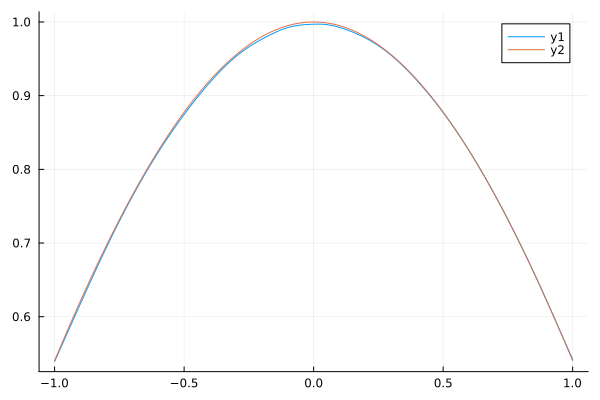

In [6]:
y_pred =  Lux.apply(tstate.model, x, tstate.parameters, tstate.states)[1] 
plot(x[1, :], y_pred[1, :])
plot!(x[1, :], y[1, :])

In [21]:
tstate

TrainState
    model: Chain{@NamedTuple{layer_1::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_2::Dense{typeof(tanh), Int64, Int64, Nothing, Nothing, Static.True}, layer_3::Dense{typeof(identity), Int64, Int64, Nothing, Nothing, Static.True}}, Nothing}((layer_1 = Dense(1 => 50, tanh), layer_2 = Dense(50 => 50, tanh), layer_3 = Dense(50 => 1)), nothing)
    # of parameters: 2701
    # of states: 0
    optimizer: Adam(0.01, (0.9, 0.999), 1.0e-8)
    step: 5000

In [22]:
tstate.parameters

(layer_1 = (weight = Float32[2.0445018; 2.9940991; … ; 2.0273445; 1.511631;;], bias = Float32[-1.1881005, -0.23867013, -0.6016198, 0.11873976, -0.57913005, 0.26602063, 0.21551885, 0.93271345, -1.0550431, 0.8898405  …  -0.27659, -0.45250306, 0.28708574, 0.23344292, 0.6885213, -0.8370268, 0.8608482, -0.92144406, 0.9368185, -0.8768587]), layer_2 = (weight = Float32[-0.101220466 -0.14551114 … 0.114197366 0.15800159; 0.3818086 0.22171836 … -0.071678 -0.15817331; … ; 0.06795889 0.11646788 … -0.010812044 0.18265595; -0.19501162 -0.39334008 … -0.276741 0.10038914], bias = Float32[0.086013205, -0.063853934, -0.10284613, -0.05696063, 0.13112669, 0.08719656, 0.056009073, 0.025852446, 0.013817264, 0.066325024  …  0.052050725, 0.14875597, 0.08450182, -0.109927, -0.0158863, -0.07412075, 0.0071267546, -0.08531047, -0.120252825, 0.1487851]), layer_3 = (weight = Float32[0.026334338 0.13665856 … -3.460118f-5 -0.00016310197], bias = Float32[0.095326416]))

In [23]:
tstate.states

(layer_1 = NamedTuple(), layer_2 = NamedTuple(), layer_3 = NamedTuple())

In [31]:
smodel = StatefulLuxLayer{true}(tstate.model, tstate.parameters, tstate.states)
f(x) = smodel(x)#only(Zygote.gradient(sum ∘ smodel, x))

only(Zygote.gradient(sum ∘ f, x))

1×200 Matrix{Float32}:
 0.781215  0.783639  0.785574  0.787008  …  -0.791278  -0.787856  -0.783465

In [33]:
smodel

StatefulLuxLayer{true}(
    Chain(
        layer_1 = Dense(1 => 50, tanh),  # 100 parameters
        layer_2 = Dense(50 => 50, tanh),  # 2_550 parameters
        layer_3 = Dense(50 => 1),       # 51 parameters
    ),
)         # Total: 2_701 parameters,
          #        plus 0 states.

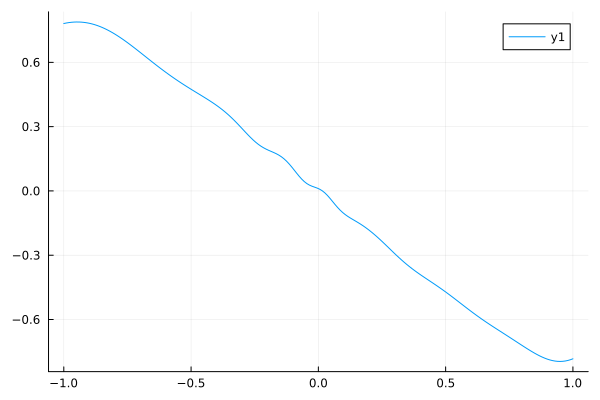

In [30]:
plot(x[1, :], f(x)')
#plot!(x[1, :],  smodel(x[1, :])')


In [53]:
using LinearAlgebra
f(x) = trial(tstate.model, x, tstate.parameters, tstate.states)
#smodel = StatefulLuxLayer{true}(tstate.model, tstate.parameters, tstate.states)
#f(x) = smodel(x)
#J = TaylorDiff.derivative(f, x, Float32.(ones(size(x))), Val(1)) 
#∂x_fd = ForwardDiff.derivative(f(x), x, Float32.(ones(size(x))), Val(1))
dydx = ForwardDiff.derivative(f, x) 
#diagonal = diag(dydx)

plot(x[1, :], f(x)')
# plot!(x[1, :], -sin.(x[1, :]))


DimensionMismatch: DimensionMismatch: derivative(f, x) expects that x is a real number. Perhaps you meant gradient(f, x)?

In [41]:
J

1×200 Matrix{Float32}:
 0.200447  0.0109787  -0.0866627  -0.119161  …  0.91741  0.902176  0.886314

In [68]:
x = [1f0]
f(x) = sin.(x)
dydx = ForwardDiff.derivative(f, x) 

DimensionMismatch: DimensionMismatch: derivative(f, x) expects that x is a real number. Perhaps you meant gradient(f, x)?

In [74]:
sum ∘ f(x)
ForwardDiff.gradient(sum ∘ f(x), x)

MethodError: MethodError: objects of type Vector{Float32} are not callable
Use square brackets [] for indexing an Array.
The object of type `Vector{Float32}` exists, but no method is defined for this combination of argument types when trying to treat it as a callable object.